In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1,
                            n_classes=3, n_clusters_per_class=1)
# Print some data
print(X[:2])
print(y[:2])

[[ 0.90394545  0.35413361]
 [-1.03106689 -1.05752257]]
[0 2]


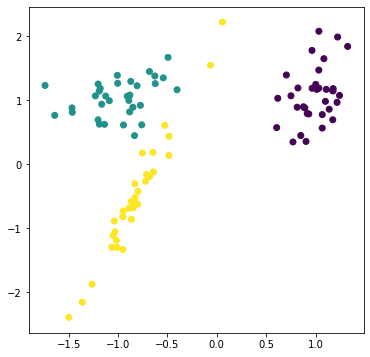

In [3]:
# Visualize points
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [4]:
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)

# Divide into train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, train_size=0.8)


In [5]:
# Build baseline model
NB_classifier = BernoulliNB()
NB_classifier.fit(X_train, y_train)
confusion_matrix(y_test, NB_classifier.predict(X_test))

array([[7, 0, 0],
       [0, 6, 0],
       [0, 1, 6]], dtype=int64)

In [34]:
# Build torch model
device = "cuda" if torch.cuda.is_available else "cpu"

class Classifier(nn.Module):
    
    def __init__(self) -> None:
        super(Classifier, self).__init__()
        self.linear = nn.Linear(2, 25)
        self.linear2 = nn.Linear(25, 10)
        self.linear3 = nn.Linear(10, 3)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = F.relu(self.linear(x))
        x = self.dropout(x)
        x = F.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.linear3(x)
        return x

model = Classifier()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)        

X_train_t, X_test_t = torch.tensor(X_train, dtype=torch.float), torch.tensor(X_test, dtype=torch.float)
y_train_t, y_test_t = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

batch_train = 8
batch_test = 8

train_loader = DataLoader(train_ds, batch_size=batch_train, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_test, shuffle=True)


In [45]:
# Train torch model
epochs = 50

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_conf_matrix = {}
    #train_conf_matrix['Pr0_Ac0'] = 0
    #train_conf_matrix['Pr0_Ac1'] = 0
    #train_conf_matrix['Pr1_Ac0'] = 0
    #train_conf_matrix['Pr1_Ac1'] = 0
    for samples, targets in train_loader:
        optimizer.zero_grad()
        samples, targets = samples.to(device), targets.to(device)
        output = model.forward(samples)
        loss = criterion(output, targets)
        train_loss += loss.item() * len(samples)
        loss.backward()
        optimizer.step()
        
        '''
        output = output.tolist()
        targets = targets.tolist()
        for i in range(len(samples)):
            if targets[i] == 0 and output[i] < 0.5:
                train_conf_matrix['Pr0_Ac0'] += 1
            elif targets[i] == 1 and output[i] < 0.5:
                train_conf_matrix['Pr0_Ac1'] += 1
            elif targets[i] == 0 and not(output[i] < 0.5):
                train_conf_matrix['Pr1_Ac0'] += 1
            elif targets[i] == 1 and not(output[i] < 0.5):
                train_conf_matrix['Pr1_Ac1'] += 1
        '''
    else:
        train_loss /= len(train_ds)
    
    with torch.no_grad():
        model.eval()
        test_loss = 0
        '''
        test_conf_matrix = {}
        test_conf_matrix['Pr0_Ac0'] = 0
        test_conf_matrix['Pr0_Ac1'] = 0
        test_conf_matrix['Pr1_Ac0'] = 0
        test_conf_matrix['Pr1_Ac1'] = 0
        '''
        for samples, targets in test_loader:
            samples, targets = samples.to(device), targets.to(device)
            output = model.forward(samples)
            loss = criterion(output, targets)
            test_loss += loss.item() * len(samples)
            '''
            output = output.tolist()
            targets = targets.tolist()
            for i in range(len(samples)):
                if targets[i] == 0 and output[i] < 0.5:
                    test_conf_matrix['Pr0_Ac0'] += 1
                elif targets[i] == 1 and output[i] < 0.5:
                    test_conf_matrix['Pr0_Ac1'] += 1
                elif targets[i] == 0 and not(output[i] < 0.5):
                    test_conf_matrix['Pr1_Ac0'] += 1
                elif targets[i] == 1 and not(output[i] < 0.5):
                    test_conf_matrix['Pr1_Ac1'] += 1
            '''
        else:
            test_loss /= len(test_ds)
    
    print(f"Epoch {epoch+1} | "
          f"Train loss: {train_loss:.6f} | "
          f"Test loss: {test_loss:.6f}")        
    #print(f"Train confusion matrix: {train_conf_matrix}")
    #print(f"Test confusion matrix: {test_conf_matrix}")


Epoch 1 | Train loss: 0.919710 | Test loss: 0.868865
Epoch 2 | Train loss: 0.892493 | Test loss: 0.825242
Epoch 3 | Train loss: 0.861391 | Test loss: 0.778668
Epoch 4 | Train loss: 0.820064 | Test loss: 0.730537
Epoch 5 | Train loss: 0.800007 | Test loss: 0.678926
Epoch 6 | Train loss: 0.727357 | Test loss: 0.625631
Epoch 7 | Train loss: 0.706073 | Test loss: 0.569427
Epoch 8 | Train loss: 0.668718 | Test loss: 0.513871
Epoch 9 | Train loss: 0.602717 | Test loss: 0.463848
Epoch 10 | Train loss: 0.554947 | Test loss: 0.414881
Epoch 11 | Train loss: 0.562240 | Test loss: 0.369192
Epoch 12 | Train loss: 0.489068 | Test loss: 0.328093
Epoch 13 | Train loss: 0.475832 | Test loss: 0.293790
Epoch 14 | Train loss: 0.396460 | Test loss: 0.261630
Epoch 15 | Train loss: 0.393991 | Test loss: 0.233169
Epoch 16 | Train loss: 0.424646 | Test loss: 0.208187
Epoch 17 | Train loss: 0.368379 | Test loss: 0.188266
Epoch 18 | Train loss: 0.328060 | Test loss: 0.171311
Epoch 19 | Train loss: 0.338181 | Tes

In [32]:
output

tensor([[-0.5065, -0.0320,  0.1544],
        [-0.3158,  0.2017,  0.0463],
        [-0.3820,  0.0146,  0.1627],
        [-0.1860,  0.1572,  0.2190],
        [-0.0289,  0.1906,  0.2225],
        [-0.0645,  0.0955,  0.2729],
        [-0.0133,  0.1582,  0.1566],
        [-0.2763,  0.2652,  0.3632]], device='cuda:0', grad_fn=<AddmmBackward>)

In [33]:
targets

tensor([0., 0., 0., 1., 0., 1., 2., 0.], device='cuda:0')

In [46]:
torch.argmax(model.forward(X_test_t.to(device)), dim=1).tolist()

[0, 0, 2, 2, 2, 0, 1, 1, 1, 0, 0, 1, 2, 0, 2, 1, 0, 2, 1, 2]

In [47]:
y_test_t

tensor([0, 0, 2, 2, 2, 0, 1, 1, 1, 0, 0, 1, 2, 0, 2, 1, 0, 2, 1, 2])

In [48]:
input1 = torch.randn(100, 128)
input2 = torch.randn(100, 128)
output = F.cosine_similarity(input1, input2)
output.shape

torch.Size([100])

In [49]:
output[1]

tensor(-0.0939)